In [ ]:
%pip install ms-swift -U
%pip install transformers -U

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 使用Python


#### 训练
导入一些库：

In [ ]:
# 导入操作系统相关的库
import os
# 设置CUDA可见设备为第0块GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 从swift.llm模块导入模型和分词器加载函数
# get_model_tokenizer: 获取模型和分词器
# load_dataset: 加载数据集
# get_template: 获取对话模板
# EncodePreprocessor: 文本编码预处理器
from swift.llm import get_model_tokenizer, load_dataset, get_template, EncodePreprocessor

# 从swift.utils模块导入工具函数
# get_logger: 获取日志记录器
# find_all_linears: 查找模型中所有线性层（用于LoRA）
# get_model_parameter_info: 获取模型参数信息
# plot_images: 绘制图像
# seed_everything: 设置随机种子确保实验可重复
from swift.utils import get_logger, find_all_linears, get_model_parameter_info, plot_images, seed_everything

# 从swift.tuners模块导入模型微调相关类
# Swift: 微调框架主类
# LoraConfig: LoRA（Low-Rank Adaptation）配置类
from swift.tuners import Swift, LoraConfig

# 从swift.trainers模块导入训练器和训练参数
# Seq2SeqTrainer: 序列到序列训练器
# Seq2SeqTrainingArguments: 序列到序列训练参数配置
from swift.trainers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# 从functools导入partial函数，用于创建偏函数
from functools import partial

# 获取日志记录器实例
logger = get_logger()
# 设置全局随机种子为42，确保实验结果可重复
seed_everything(42)

[INFO:swift] Global seed set to 42


42

设置训练的超参数：

In [ ]:
# ========== 模型配置 ==========
# 指定要使用的模型路径或模型ID
model_id_or_path = '/home/work/hd/_models/base/qwen3-4b-thinking'  # model_id or model_path
# 设置系统提示语，定义AI助手的基本行为
system = 'You are a helpful assistant.'
# 设置训练输出目录，保存模型检查点和日志
output_dir = 'output'

# ========== 数据集配置 ==========
# 定义训练数据集列表，#后的数字表示使用该数据集的前N条数据
# AI-ModelScope/alpaca-gpt4-data-zh: 中文指令数据集，使用前500条
# AI-ModelScope/alpaca-gpt4-data-en: 英文指令数据集，使用前500条  
# swift/self-cognition: 自我认知数据集，使用前500条
dataset = ['AI-ModelScope/alpaca-gpt4-data-zh#500', 'AI-ModelScope/alpaca-gpt4-data-en#500',
           'swift/self-cognition#500']  # dataset_id or dataset_path
# 数据集随机种子，确保数据划分的可重复性
data_seed = 42
# 输入序列的最大长度（tokens数量）
max_length = 2048
# 验证集划分比例，0.01表示1%的数据用作验证集
split_dataset_ratio = 0.01  # 切分验证集
# 数据预处理时使用的进程数，加快数据处理速度
num_proc = 4  # 预处理的进程数

# ========== 自我认知数据集个性化配置 ==========
# 替换自我认知数据集中的填充符：{{NAME}}, {{AUTHOR}}
# 模型的中文名和英文名，用于替换数据集中的{{NAME}}占位符
model_name = ['精衡', 'Jingheng']  # 模型的中文名和英文名
# 模型作者的中文名和英文名，用于替换数据集中的{{AUTHOR}}占位符
model_author = ['叶博韬', 'YE SEVERIN']  # 模型作者的中文名和英文名

# ========== LoRA微调配置 ==========
# LoRA的秩（rank），控制低秩矩阵的维度，越小参数越少但表达能力较弱
lora_rank = 8
# LoRA的缩放因子，控制LoRA权重的影响程度，通常设为rank的4倍
lora_alpha = 32

# ========== 训练超参数配置 ==========
# 创建序列到序列训练参数对象
training_args = Seq2SeqTrainingArguments(
    # 模型检查点和日志的输出目录
    output_dir=output_dir,
    # 学习率，控制参数更新的步长
    learning_rate=1e-4,
    # 每个GPU上的训练批次大小
    per_device_train_batch_size=1,
    # 每个GPU上的验证批次大小
    per_device_eval_batch_size=1,
    # 启用梯度检查点，节省显存但增加计算时间
    gradient_checkpointing=True,
    # 权重衰减系数，防止过拟合的正则化技术
    weight_decay=0.1,
    # 学习率调度器类型，cosine表示余弦退火调度
    lr_scheduler_type='cosine',
    # 预热比例，训练初期逐渐增加学习率的步数占总步数的比例
    warmup_ratio=0.05,
    # 日志记录工具，tensorboard用于可视化训练过程
    report_to=['tensorboard'],
    # 是否在第一步就开始记录日志
    logging_first_step=True,
    # 模型保存策略，'steps'表示按步数保存
    save_strategy='steps',
    # 每隔50步保存一次模型检查点
    save_steps=50,
    # 模型评估策略，'steps'表示按步数评估
    eval_strategy='steps',
    # 每隔50步进行一次模型评估
    eval_steps=50,
    # 梯度累积步数，实际批次大小 = per_device_train_batch_size × gradient_accumulation_steps
    gradient_accumulation_steps=16,
    # 训练轮数，完整遍历数据集的次数
    num_train_epochs=1,
    # 选择最佳模型的评估指标，'loss'表示以损失函数为准
    metric_for_best_model='loss',
    # 最多保存的检查点数量，超过后删除最旧的
    save_total_limit=2,
    # 每隔5步记录一次训练日志
    logging_steps=5,
    # 数据加载器使用的工作进程数
    dataloader_num_workers=1,
    # 数据相关的随机种子
    data_seed=data_seed,
)

# 将输出目录转换为绝对路径
output_dir = os.path.abspath(os.path.expanduser(output_dir))
# 记录输出目录的绝对路径
logger.info(f'output_dir: {output_dir}')

[INFO:swift] output_dir: /home/work/hd/2_core/1_train/output


获取模型和对话template，并将可训练的lora层加入到模型中：

In [ ]:
# ========== 模型和分词器加载 ==========
# 加载指定路径的模型和分词器，指定模型类型为qwen3_thinking
# model_type参数用于区分同一目录下的不同模型变体
model, tokenizer = get_model_tokenizer(model_id_or_path, model_type='qwen3_thinking')
# 打印模型的基本信息（架构、参数量等）
logger.info(f'model_info: {model.model_info}')

# ========== 对话模板配置 ==========
# 获取模型对应的对话模板，用于格式化输入输出
# model.model_meta.template: 模型元数据中定义的模板类型
# default_system: 设置默认的系统提示语
# max_length: 限制输入序列的最大长度
template = get_template(model.model_meta.template, tokenizer, default_system=system, max_length=max_length)
# 将模板设置为训练模式，这会影响模板的行为（如是否包含特殊token）
template.set_mode('train')

# ========== LoRA配置和模型准备 ==========
# 查找模型中所有的线性层（Linear layers），这些层将被LoRA适配
# LoRA只对线性层进行低秩分解，不影响其他类型的层
target_modules = find_all_linears(model)

# 创建LoRA配置对象
lora_config = LoraConfig(
    task_type='CAUSAL_LM',  # 任务类型：因果语言模型（自回归生成）
    r=lora_rank,            # LoRA的秩，控制低秩矩阵的维度
    lora_alpha=lora_alpha,  # LoRA的缩放因子，控制适配权重的影响程度
    target_modules=target_modules  # 指定要应用LoRA的模块列表
)

# 使用Swift框架为模型添加LoRA适配器
# 这会在原模型的线性层旁边添加低秩分解的权重矩阵
model = Swift.prepare_model(model, lora_config)
# 打印LoRA配置信息
logger.info(f'lora_config: {lora_config}')

# ========== 模型信息输出 ==========
# 打印完整的模型结构（包括新添加的LoRA层）
logger.info(f'model: {model}')
# 获取并打印模型参数统计信息（总参数量、可训练参数量等）
model_parameter_info = get_model_parameter_info(model)
logger.info(f'model_parameter_info: {model_parameter_info}')

[INFO:swift] Setting torch_dtype: torch.bfloat16
[INFO:swift] model_kwargs: {'device_map': 'cuda:0'}
`torch_dtype` is deprecated! Use `dtype` instead!
[INFO:swift] model_kwargs: {'device_map': 'cuda:0'}
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]
[INFO:swift] model_info: ModelInfo(model_type='qwen3_thinking', model_dir='/home/work/hd/_models/base/qwen3-4b-thinking', torch_dtype=torch.bfloat16, max_model_len=262144, quant_method=None, quant_bits=None, rope_scaling=None, is_moe_model=False, config=Qwen3Config {
  "architectures": [
    "Qwen3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 9728,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attentio

下载并载入数据集，并切分成训练集和验证集，

然后将文本编码成tokens：

In [ ]:
# ========== 数据集加载和划分 ==========
# 加载指定的数据集并自动划分为训练集和验证集
# dataset: 数据集列表，包含中文、英文指令数据和自我认知数据
# split_dataset_ratio: 验证集比例（0.01 = 1%）
# num_proc: 并行处理进程数，加快数据加载速度
# model_name/model_author: 用于替换自我认知数据集中的{{NAME}}和{{AUTHOR}}占位符
# seed: 随机种子，确保数据划分的可重复性
train_dataset, val_dataset = load_dataset(dataset, split_dataset_ratio=split_dataset_ratio, num_proc=num_proc,
        model_name=model_name, model_author=model_author, seed=data_seed)

# ========== 数据集信息输出 ==========
# 打印训练集的基本信息（数据条数、格式等）
logger.info(f'train_dataset: {train_dataset}')
# 打印验证集的基本信息
logger.info(f'val_dataset: {val_dataset}')
# 打印训练集第一条原始数据样本，查看数据格式和内容
logger.info(f'train_dataset[0]: {train_dataset[0]}')

# ========== 数据编码预处理 ==========
# 创建编码预处理器，将文本转换为模型可理解的token序列
# template: 使用之前配置的对话模板来格式化数据
# 对训练集进行编码处理：文本 -> token IDs
train_dataset = EncodePreprocessor(template=template)(train_dataset, num_proc=num_proc)
# 对验证集进行编码处理：文本 -> token IDs
val_dataset = EncodePreprocessor(template=template)(val_dataset, num_proc=num_proc)
# 打印编码后的训练集第一条数据，查看token化后的格式
logger.info(f'encoded_train_dataset[0]: {train_dataset[0]}')

# ========== 样本展示 ==========
# 使用模板的打印功能展示一条完整的训练样本
# 这会显示格式化后的输入输出对，包括系统提示、用户输入、模型回答等
template.print_inputs(train_dataset[0])

[INFO:swift] SelfCognitionPreprocessor has been successfully configured with name: ['精衡', 'Jingheng'], author: ['叶博韬', 'YE SEVERIN'].
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: AI-ModelScope/alpaca-gpt4-data-zh
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: AI-ModelScope/alpaca-gpt4-data-zh
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: AI-ModelScope/alpaca-gpt4-data-en
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: AI-ModelScope/alpaca-gpt4-data-en
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: swift/self-cognition
[INFO:swift] Downloading the dataset from ModelScope, dataset_id: swift/self-cognition
Map (num_proc=4): 100%|██████████| 108/108 [00:00<00:00, 986.64 examples/s]
[WARNING:swift] dataset_sample:499 is greater than len(dataset):107, repeated sampling will be performed.

[WARNING:swift] dataset_sample:499 is greater than len(dataset):107, repeated sampling will be performed.
[IN

初始化trainer并开始训练：

In [ ]:
# ========== 模型训练前准备 ==========
# 启用输入梯度计算，这是使用梯度检查点（gradient checkpointing）时的必要设置
# 梯度检查点可以节省显存，但需要在前向传播时重新计算某些中间激活值
model.enable_input_require_grads()  # 兼容gradient checkpointing

# ========== 训练器初始化 ==========
# 创建序列到序列训练器对象，配置所有训练相关组件
trainer = Seq2SeqTrainer(
    model=model,                        # 要训练的模型（已添加LoRA适配器）
    args=training_args,                 # 训练参数配置（学习率、批次大小、保存策略等）
    data_collator=template.data_collator,  # 数据整理器，用于将批次数据转换为模型输入格式
    train_dataset=train_dataset,        # 训练数据集（已编码为token序列）
    eval_dataset=val_dataset,           # 验证数据集（用于评估模型性能）
    template=template,                  # 对话模板（用于格式化输入输出）
)

# ========== 开始训练 ==========
# 启动训练过程，这将执行以下步骤：
# 1. 前向传播：计算模型输出和损失
# 2. 反向传播：计算梯度
# 3. 参数更新：使用优化器更新LoRA权重
# 4. 定期保存检查点和记录日志
# 5. 定期在验证集上评估模型性能
trainer.train()

# ========== 训练完成后处理 ==========
# 获取最后保存的模型检查点路径
# trainer.state.last_model_checkpoint 包含了训练过程中最后一次保存的模型路径
last_model_checkpoint = trainer.state.last_model_checkpoint
# 记录最终模型检查点的位置，用于后续推理
logger.info(f'last_model_checkpoint: {last_model_checkpoint}')

The model is already on multiple devices. Skipping the move to device specified in `args`.
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
[INFO:swift] use_reentrant: True
[INFO:swift] use_reentrant: True
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokeniz

{'loss': 2.14067459, 'grad_norm': 2.05222344, 'learning_rate': 2e-05, 'token_acc': 0.55839002, 'epoch': 0.01, 'global_step/max_steps': '1/94', 'percentage': '1.06%', 'elapsed_time': '6s', 'remaining_time': '9m 48s', 'memory(GiB)': 8.91, 'train_speed(iter/s)': 0.157961}


Train:   5%|▌         | 5/94 [00:27<07:59,  5.39s/it]

{'loss': 1.93902969, 'grad_norm': 1.88177383, 'learning_rate': 0.0001, 'token_acc': 0.6216431, 'epoch': 0.05, 'global_step/max_steps': '5/94', 'percentage': '5.32%', 'elapsed_time': '27s', 'remaining_time': '8m 12s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.180765}


Train:  11%|█         | 10/94 [00:53<07:16,  5.20s/it]

{'loss': 1.5915329, 'grad_norm': 1.32298744, 'learning_rate': 9.922e-05, 'token_acc': 0.63710034, 'epoch': 0.11, 'global_step/max_steps': '10/94', 'percentage': '10.64%', 'elapsed_time': '53s', 'remaining_time': '7m 29s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.186835}


Train:  16%|█▌        | 15/94 [01:19<06:48,  5.17s/it]

{'loss': 1.40351467, 'grad_norm': 0.62444812, 'learning_rate': 9.692e-05, 'token_acc': 0.64086078, 'epoch': 0.16, 'global_step/max_steps': '15/94', 'percentage': '15.96%', 'elapsed_time': '1m 19s', 'remaining_time': '6m 57s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.1891}


Train:  21%|██▏       | 20/94 [01:44<06:19,  5.13s/it]

{'loss': 1.31425562, 'grad_norm': 0.75998163, 'learning_rate': 9.315e-05, 'token_acc': 0.65148975, 'epoch': 0.21, 'global_step/max_steps': '20/94', 'percentage': '21.28%', 'elapsed_time': '1m 44s', 'remaining_time': '6m 28s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.190505}


Train:  27%|██▋       | 25/94 [02:10<05:52,  5.11s/it]

{'loss': 1.24976692, 'grad_norm': 0.57984459, 'learning_rate': 8.805e-05, 'token_acc': 0.66701058, 'epoch': 0.27, 'global_step/max_steps': '25/94', 'percentage': '26.60%', 'elapsed_time': '2m 10s', 'remaining_time': '6m 0s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.191604}


Train:  32%|███▏      | 30/94 [02:35<05:25,  5.08s/it]

{'loss': 1.29146032, 'grad_norm': 1.02990079, 'learning_rate': 8.176e-05, 'token_acc': 0.65219378, 'epoch': 0.32, 'global_step/max_steps': '30/94', 'percentage': '31.91%', 'elapsed_time': '2m 35s', 'remaining_time': '5m 32s', 'memory(GiB)': 11.63, 'train_speed(iter/s)': 0.19244}


Train:  37%|███▋      | 35/94 [03:01<05:01,  5.11s/it]

{'loss': 1.39475956, 'grad_norm': 0.7445004, 'learning_rate': 7.449e-05, 'token_acc': 0.63206578, 'epoch': 0.38, 'global_step/max_steps': '35/94', 'percentage': '37.23%', 'elapsed_time': '3m 1s', 'remaining_time': '5m 5s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.192894}


Train:  43%|████▎     | 40/94 [03:26<04:33,  5.07s/it]

{'loss': 1.32103796, 'grad_norm': 0.62134475, 'learning_rate': 6.645e-05, 'token_acc': 0.66061055, 'epoch': 0.43, 'global_step/max_steps': '40/94', 'percentage': '42.55%', 'elapsed_time': '3m 26s', 'remaining_time': '4m 39s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193449}


Train:  48%|████▊     | 45/94 [03:52<04:07,  5.06s/it]

{'loss': 1.15498009, 'grad_norm': 0.73626763, 'learning_rate': 5.791e-05, 'token_acc': 0.67277787, 'epoch': 0.48, 'global_step/max_steps': '45/94', 'percentage': '47.87%', 'elapsed_time': '3m 52s', 'remaining_time': '4m 12s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193915}


Train:  53%|█████▎    | 50/94 [04:17<03:43,  5.07s/it]

{'loss': 1.26454611, 'grad_norm': 0.60400987, 'learning_rate': 4.912e-05, 'token_acc': 0.66360734, 'epoch': 0.54, 'global_step/max_steps': '50/94', 'percentage': '53.19%', 'elapsed_time': '4m 17s', 'remaining_time': '3m 46s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.194242}



Val: 100%|██████████| 11/11 [00:00<00:00, 14.12it/s]t]



{'eval_loss': 1.31140316, 'eval_runtime': 0.9237, 'eval_samples_per_second': 11.909, 'eval_steps_per_second': 11.909, 'eval_token_acc': 0.61910448, 'epoch': 0.54, 'global_step/max_steps': '50/94', 'percentage': '53.19%', 'elapsed_time': '4m 18s', 'remaining_time': '3m 47s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193539}


[INFO:swift] Saving model checkpoint to /home/work/hd/2_core/1_train/output/checkpoint-50
Train:  59%|█████▊    | 55/94 [04:44<03:21,  5.17s/it]

{'loss': 1.22144356, 'grad_norm': 0.72191638, 'learning_rate': 4.035e-05, 'token_acc': 0.67193468, 'epoch': 0.59, 'global_step/max_steps': '55/94', 'percentage': '58.51%', 'elapsed_time': '4m 44s', 'remaining_time': '3m 21s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193402}


Train:  64%|██████▍   | 60/94 [05:09<02:53,  5.09s/it]

{'loss': 1.28716459, 'grad_norm': 0.49499837, 'learning_rate': 3.189e-05, 'token_acc': 0.65603003, 'epoch': 0.64, 'global_step/max_steps': '60/94', 'percentage': '63.83%', 'elapsed_time': '5m 9s', 'remaining_time': '2m 55s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193708}


Train:  69%|██████▉   | 65/94 [05:35<02:26,  5.07s/it]

{'loss': 1.22448025, 'grad_norm': 0.60430157, 'learning_rate': 2.399e-05, 'token_acc': 0.6658502, 'epoch': 0.7, 'global_step/max_steps': '65/94', 'percentage': '69.15%', 'elapsed_time': '5m 35s', 'remaining_time': '2m 29s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.193984}


Train:  74%|███████▍  | 70/94 [06:00<02:01,  5.05s/it]

{'loss': 1.24119921, 'grad_norm': 0.78643107, 'learning_rate': 1.689e-05, 'token_acc': 0.66622604, 'epoch': 0.75, 'global_step/max_steps': '70/94', 'percentage': '74.47%', 'elapsed_time': '6m 0s', 'remaining_time': '2m 3s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.194264}


Train:  80%|███████▉  | 75/94 [06:25<01:35,  5.02s/it]

{'loss': 0.99853811, 'grad_norm': 0.81075078, 'learning_rate': 1.083e-05, 'token_acc': 0.70998237, 'epoch': 0.81, 'global_step/max_steps': '75/94', 'percentage': '79.79%', 'elapsed_time': '6m 25s', 'remaining_time': '1m 37s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.194608}


Train:  85%|████████▌ | 80/94 [06:50<01:10,  5.03s/it]

{'loss': 1.20700426, 'grad_norm': 0.68755728, 'learning_rate': 5.98e-06, 'token_acc': 0.66387205, 'epoch': 0.86, 'global_step/max_steps': '80/94', 'percentage': '85.11%', 'elapsed_time': '6m 50s', 'remaining_time': '1m 11s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.194837}


Train:  90%|█████████ | 85/94 [07:15<00:45,  5.04s/it]

{'loss': 1.14922762, 'grad_norm': 0.54358047, 'learning_rate': 2.5e-06, 'token_acc': 0.68236792, 'epoch': 0.91, 'global_step/max_steps': '85/94', 'percentage': '90.43%', 'elapsed_time': '7m 15s', 'remaining_time': '46s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.195036}


Train:  96%|█████████▌| 90/94 [07:41<00:20,  5.04s/it]

{'loss': 1.11148405, 'grad_norm': 0.80076325, 'learning_rate': 5e-07, 'token_acc': 0.6948938, 'epoch': 0.97, 'global_step/max_steps': '90/94', 'percentage': '95.74%', 'elapsed_time': '7m 41s', 'remaining_time': '20s', 'memory(GiB)': 12.48, 'train_speed(iter/s)': 0.195222}


Val: 100%|██████████| 11/11 [00:00<00:00, 14.59it/s]


{'eval_loss': 1.2806505, 'eval_runtime': 0.8951, 'eval_samples_per_second': 12.289, 'eval_steps_per_second': 12.289, 'eval_token_acc': 0.62089552, 'epoch': 1.0, 'global_step/max_steps': '94/94', 'percentage': '100.00%', 'elapsed_time': '7m 57s', 'remaining_time': '0s', 'memory(GiB)': 12.89, 'train_speed(iter/s)': 0.196918}


[INFO:swift] Saving model checkpoint to /home/work/hd/2_core/1_train/output/checkpoint-94
Train: 100%|██████████| 94/94 [07:58<00:00,  5.09s/it]
[INFO:swift] last_model_checkpoint: /home/work/hd/2_core/1_train/output/checkpoint-94

[INFO:swift] last_model_checkpoint: /home/work/hd/2_core/1_train/output/checkpoint-94


{'train_runtime': 478.0244, 'train_samples_per_second': 3.115, 'train_steps_per_second': 0.197, 'train_loss': 1.29666271, 'epoch': 1.0, 'global_step/max_steps': '94/94', 'percentage': '100.00%', 'elapsed_time': '7m 58s', 'remaining_time': '0s', 'memory(GiB)': 12.89, 'train_speed(iter/s)': 0.196648}


可视化训练的loss。其中浅黄色线条代表真实loss值，黄色线条代表经过0.9平滑系数平滑后的loss值。

你也可以使用tensorboard进行实时可视化，在命令行输入`tensorboard --logdir '{output_dir}/runs'`。

[INFO:swift] images_dir: /home/work/hd/2_core/1_train/output/images


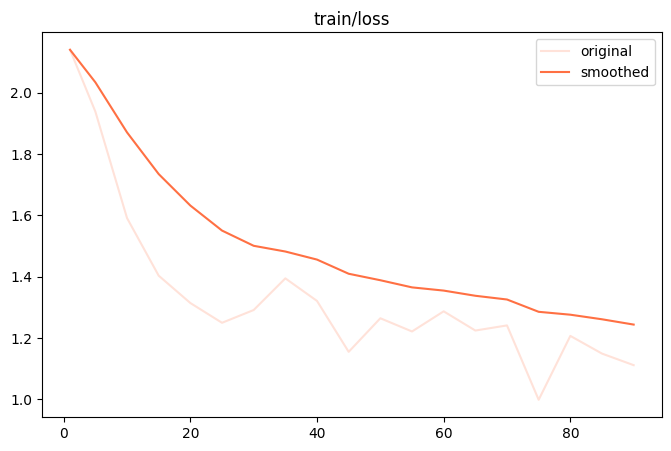

In [15]:
images_dir = os.path.join(output_dir, 'images')
logger.info(f'images_dir: {images_dir}')
plot_images(images_dir, training_args.logging_dir, ['train/loss'], 0.9)  # 保存图片

# 展示图片
from IPython.display import display
from PIL import Image
image = Image.open(os.path.join(images_dir, 'train_loss.png'))
display(image)

#### 微调后推理

导入一些库：

In [ ]:
# ========== 推理环境设置 ==========
# 导入操作系统相关库
import os
# 设置CUDA可见设备为第0块GPU（与训练时保持一致）
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# ========== 推理相关库导入 ==========
# 从swift.llm模块导入推理相关的核心类和函数
from swift.llm import (
    InferEngine,      # 推理引擎基类，定义推理接口
    InferRequest,     # 推理请求对象，封装用户输入和配置
    PtEngine,         # PyTorch推理引擎，用于加载和运行PyTorch模型
    RequestConfig,    # 请求配置对象，设置生成参数（温度、最大长度等）
    get_template      # 获取对话模板函数，用于格式化输入输出
)

设置推理的超参数：

In [ ]:
# ========== LoRA适配器路径配置 ==========
# 指定训练完成后保存的LoRA权重检查点路径
# 注意：这里需要替换为实际的训练输出路径，格式为 output/vx-xxx/checkpoint-xxx
last_model_checkpoint = 'output/vx-xxx/checkpoint-xxx'

# ========== 基础模型配置 ==========
# 指定基础模型的ID或路径（不是微调后的模型，而是原始的基础模型）
# 推理时会在这个基础模型上加载LoRA适配器权重
model_id_or_path = 'Qwen/Qwen2.5-3B-Instruct'  # model_id or model_path
# 设置系统提示语，定义AI助手的行为特征
system = 'You are a helpful assistant.'
# 指定推理后端类型，'pt'表示使用PyTorch后端
infer_backend = 'pt'

# ========== 文本生成参数配置 ==========
# 设置生成文本的最大新token数量（不包括输入部分）
max_new_tokens = 10000
# 设置生成温度，控制文本生成的随机性
# temperature=0: 确定性生成，总是选择概率最高的token
# temperature>0: 随机性生成，值越大越随机
temperature = 0
# 是否启用流式输出，True表示逐token生成并实时返回
# 流式输出可以提供更好的用户体验，类似ChatGPT的打字效果
stream = True

获取推理引擎，并载入LoRA权重：

In [ ]:
# ========== 推理引擎初始化 ==========
# 创建PyTorch推理引擎，加载基础模型并应用LoRA适配器
# model_id_or_path: 基础模型路径（原始Qwen模型）
# adapters: LoRA适配器列表，可以加载多个适配器进行组合
engine = PtEngine(model_id_or_path, adapters=[last_model_checkpoint])

# ========== 对话模板配置 ==========
# 获取与推理引擎模型匹配的对话模板
# engine.model.model_meta.template: 从模型元数据中获取模板类型
# engine.tokenizer: 使用推理引擎的分词器
# default_system: 设置默认的系统提示语
template = get_template(engine.model.model_meta.template, engine.tokenizer, default_system=system)

# ========== 设置默认模板 ==========
# 将配置好的模板设置为推理引擎的默认模板
# 这样在调用engine.infer()时会自动使用此模板格式化输入输出
# 也可以在每次调用engine.infer()时单独传入template参数
engine.default_template = template

开始推理...

In [ ]:
query_list = [
    'who are you?',
    "晚上睡不着觉怎么办？",
    '你是谁训练的？',
]

def infer_stream(engine: InferEngine, infer_request: InferRequest):
    request_config = RequestConfig(max_tokens=max_new_tokens, temperature=temperature, stream=True)
    gen_list = engine.infer([infer_request], request_config)
    query = infer_request.messages[0]['content']
    print(f'query: {query}\nresponse: ', end='')
    for resp in gen_list[0]:
        if resp is None:
            continue
        print(resp_list[0].choices[0].delta.content, end='', flush=True)
    print()

def infer(engine: InferEngine, infer_request: InferRequest):
    request_config = RequestConfig(max_tokens=max_new_tokens, temperature=temperature)
    resp_list = engine.infer([infer_request], request_config)
    query = infer_request.messages[0]['content']
    response = resp_list[0].choices[0].message.content
    print(f'query: {query}')
    print(f'response: {response}')

infer_func = infer_stream if stream else infer
for query in query_list:
    infer_func(engine, InferRequest(messages=[{'role': 'user', 'content': query}]))
    print('-' * 50)

## Web-UI

In [ ]:
# ========== Web-UI启动命令 ==========
# 使用训练好的LoRA适配器启动Web界面
# 注意：需要将 output/vx-xxx/checkpoint-xxx 替换为实际的检查点路径
# 可以通过运行 last_model_checkpoint 变量查看实际路径

# 方法1：使用实际的检查点路径（推荐）
# 先查看实际的检查点路径
print(f"实际的检查点路径: {last_model_checkpoint}")

# 方法2：启动Web-UI（需要替换为实际路径）
!CUDA_VISIBLE_DEVICES=0 \
swift web-ui \
    --model_id_or_path /home/work/hd/_models/base/qwen3-4b-thinking \
    --model_type qwen3_thinking \
    --adapters {last_model_checkpoint} \
    --temperature 0 \
    --infer_backend pt \
    --max_new_tokens 2048

实际的检查点路径: /home/work/hd/2_core/1_train/output/checkpoint-94
[WARNING:swift] Please use `swift app`.
run sh: `/home/work/hd/.venv/bin/python3 /home/work/hd/.venv/lib/python3.10/site-packages/swift/cli/app.py --model_id_or_path /home/work/hd/_models/base/qwen3-4b-thinking --model_type qwen3_thinking --adapters /home/work/hd/2_core/1_train/output/checkpoint-94 --temperature 0 --infer_backend pt --max_new_tokens 2048`
[WARNING:swift] Please use `swift app`.
run sh: `/home/work/hd/.venv/bin/python3 /home/work/hd/.venv/lib/python3.10/site-packages/swift/cli/app.py --model_id_or_path /home/work/hd/_models/base/qwen3-4b-thinking --model_type qwen3_thinking --adapters /home/work/hd/2_core/1_train/output/checkpoint-94 --temperature 0 --infer_backend pt --max_new_tokens 2048`
[INFO:swift] Successfully registered `/home/work/hd/.venv/lib/python3.10/site-packages/swift/llm/dataset/data/dataset_info.json`.
[INFO:swift] Successfully registered `/home/work/hd/.venv/lib/python3.10/site-packages/swift/l